In [177]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('/content/drive/')
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

pd.options.mode.chained_assignment = None
# %matplotlib inline
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**1.  Load the Data**

In [178]:
train_data = drive.CreateFile({'id': '1TNpBMpZVCbvF6hgP-Gvu5Iybu1hiKJkS'})
train_data.GetContentFile('train.csv')
test_data = drive.CreateFile({'id': '1d2_B-6SFGKtBwAeV3THr0459ClHfsK5C'})
test_data.GetContentFile('test.csv')

In [179]:
train_data = pd.read_csv("train.csv", index_col="PassengerId")
test_data = pd.read_csv("test.csv", index_col="PassengerId")

1.   Let's see some info about train_data
2.   Let's see some info about test_data

In [180]:
print(train_data.info())
print(train_data.isna().sum())  # amount of missied values for each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [181]:
print(test_data.info())
print(test_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


**2. Visualising the Data**


Let's see how different variables are associated with survival variable

**1)Pclass variable**

In [182]:
%%flake8
print(train_data["Pclass"].unique())
train_data[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)

There are three classes (1, 2 and 3) representing first, second or third class tickets on the boat.

As we can see with the higher Pclass passengers having a higher survival rate. 

So Pclass variable can make an impact on the final result and it makes sense to include it in the model.

**2)Name variable**

In [183]:
print(train_data["Name"])

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object


In [184]:
print(train_data.Name[1].split())

['Braund,', 'Mr.', 'Owen', 'Harris']


As we can see by splitting name we got title, surname and name of the person.

So I can suppose that the whole families either survived or died together. Maybe i'm wrong, but never mind:)

So i decided to match up surnames to group families together.

Also i wanna get titles of names in terms of there are some common ones such as Mr and Miss and some rare/unique ones such as Rev (reverend). 

I can assume that the passengers with their own titles were sagnificantly important so they might have been more likely to survive.

In order to get family name (surname) we can split name of passenger by comma and get the first entry of array.

In [185]:
print(train_data.Name[1].split(",")[0])

Braund


In order to get title we can split name of passenger by comma and get the second entry of array.After split it by dot and get the first entry of array.

In [186]:
print(train_data.Name[1].split(",")[1].split(".")[0])

 Mr


In [187]:
train_data = train_data.assign(fname=train_data.Name.str.split(",").str[0])
train_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip()
                                for i in train_data.Name],
                                index=train_data.index)
test_data = test_data.assign(fname=test_data.Name.str.split(",").str[0])
test_data["title"] = pd.Series([i.split(",")[1].split(".")[0].strip()
                               for i in test_data.Name],
                               index=test_data.index)
train_data.drop("Name", axis=1, inplace=True)
test_data.drop("Name", axis=1, inplace=True)

Let's see the amount of unique fnames and titles.

In [188]:
print(test_data.fname.nunique())
print(test_data.title.nunique())

352
9


Visualization for the number of values for each title.

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
{'Major', 'Capt', 'Dr', 'Rev', 'the Countess', 'Dona', 'Col', 'Don', 'Sir', 'Jonkheer', 'Lady'}


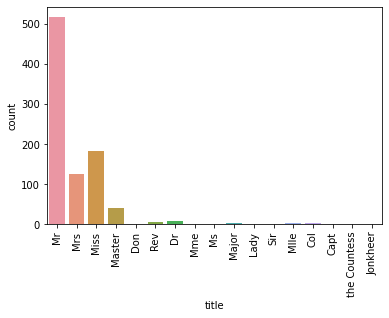

In [189]:
ts = sns.countplot(x="title", data=train_data)
ts = plt.setp(ts.get_xticklabels(), rotation=90)
print(train_data["title"].unique())
print(test_data["title"].unique())
other_titles = [title
                for title in train_data["title"]
                if title not in ["Mr", "Miss", "Master",
                                 "Mme", "Mlle", "Mrs", "Ms"]]
# these titles are more important than other common ones
other_titles.append("Dona")
print(set(other_titles))  # the unique values of other titles

There are a lot of uniques so I want to group them.

I will use the pandas dataframe replace and map functions for this.

In [190]:
common = {"Mr": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1,
                              "Mrs": 1, "Master": 2, "Other": 3}
train_data["title"] = train_data['title'].replace(other_titles, 'Other')
train_data["title"] = train_data["title"].map(common)
test_data["title"] = test_data['title'].replace(other_titles, 'Other')
test_data["title"] = test_data["title"].map(common)

In [191]:
print(train_data.title)
print(test_data.title.isna().sum())
print(train_data.title.nunique())

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    3
888    1
889    1
890    0
891    0
Name: title, Length: 891, dtype: int64
0
4


fname and title variables are not numerical so it makes sense to apply OneHotEncoder. 

We can not use map in this case in terms of our model will interpret these 
columns as quantitative variables and as the result will be inccorrect output.

We just wanna show to model the belonging of passenger to the specific family and title.

In [192]:
oh = OneHotEncoder(handle_unknown="ignore", sparse=False)
train_data = train_data.join(pd.DataFrame(oh.fit_transform(
    train_data[["fname", "title"]]), index=train_data.index))
test_data = test_data.join(pd.DataFrame(oh.transform(
    test_data[["fname", "title"]]), index=test_data.index))
train_data.drop("fname", axis=1, inplace=True)
test_data.drop("fname", axis=1, inplace=True)

**3)Sex variable**

In [193]:
print(train_data["Sex"].unique())
train_data[['Sex', 'Survived']].groupby(['Sex'],
                                        as_index=False).mean().sort_values(
                                            by='Survived', ascending=False)

['male' 'female']


,Sex,Survived
0,female,0.742038
1,male,0.188908


As we can see females have a much higher survival rate. 

It makes sense to include Sex in the model.


Across all males and females, females have a much higher survival rate. 

But what if wealthy males have a higher survival than poor females? It might make sense to segment this out explicity.

Let's create a new feature sex_class that represents all above.

In [194]:
interactions = train_data.assign(
    sex_class=train_data['Sex'] + "_" + train_data['Pclass'].astype("str"))
interactions[['sex_class', 'Survived']].groupby(
    ['sex_class'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)

,sex_class,Survived
0,female_1,0.968085
1,female_2,0.921053
2,female_3,0.500000
3,male_1,0.368852
4,male_2,0.157407
5,male_3,0.135447


In [195]:
train_data = train_data.assign(
    sex_class=train_data['Sex'] + "_" + train_data['Pclass'].astype("str"))
test_data = test_data.assign(
    sex_class=test_data['Sex'] + "_" + test_data['Pclass'].astype("str"))
print(train_data)

             Survived  Pclass     Sex   Age  ...  668  669  670  sex_class
PassengerId                                  ...                          
1                   0       3    male  22.0  ...  0.0  0.0  0.0     male_3
2                   1       1  female  38.0  ...  1.0  0.0  0.0   female_1
3                   1       3  female  26.0  ...  1.0  0.0  0.0   female_3
4                   1       1  female  35.0  ...  1.0  0.0  0.0   female_1
5                   0       3    male  35.0  ...  0.0  0.0  0.0     male_3
...               ...     ...     ...   ...  ...  ...  ...  ...        ...
887                 0       2    male  27.0  ...  0.0  0.0  1.0     male_2
888                 1       1  female  19.0  ...  1.0  0.0  0.0   female_1
889                 0       3  female   NaN  ...  1.0  0.0  0.0   female_3
890                 1       1    male  26.0  ...  0.0  0.0  0.0     male_1
891                 0       3    male  32.0  ...  0.0  0.0  0.0     male_3

[891 rows x 683 columns]

Pclass variable is encoded numerically, but it is ordinal and it will be treated the same as something like Age by most of the models.

So let's encode it by using dummy variables.

In [196]:
train_data = train_data.join(pd.get_dummies(train_data['Pclass'],
                                            prefix="Pclass"))
test_data = test_data.join(pd.get_dummies(test_data['Pclass'],
                                          prefix="Pclass"))
print(train_data)

             Survived  Pclass     Sex  ...  Pclass_1  Pclass_2  Pclass_3
PassengerId                            ...                              
1                   0       3    male  ...         0         0         1
2                   1       1  female  ...         1         0         0
3                   1       3  female  ...         0         0         1
4                   1       1  female  ...         1         0         0
5                   0       3    male  ...         0         0         1
...               ...     ...     ...  ...       ...       ...       ...
887                 0       2    male  ...         0         1         0
888                 1       1  female  ...         1         0         0
889                 0       3  female  ...         0         0         1
890                 1       1    male  ...         1         0         0
891                 0       3    male  ...         0         0         1

[891 rows x 686 columns]


Let's encode Sex variable as numeric by using the map method.

In [197]:
train_data["Sex"] = train_data["Sex"].map({"female": 0, "male": 1})
test_data["Sex"] = test_data["Sex"].map({"female": 0, "male": 1})

The same stuff for sex_class.

In [198]:
sex_class = {"female_1": 0, "female_2": 1, "female_3": 2,
             "male_1": 4, "male_2": 5, "male_3": 6}
train_data["sex_class"] = train_data["sex_class"].map(sex_class)
test_data["sex_class"] = test_data["sex_class"].map(sex_class)
print(train_data.sex_class)

PassengerId
1      6
2      0
3      2
4      0
5      6
      ..
887    5
888    0
889    2
890    4
891    6
Name: sex_class, Length: 891, dtype: int64


**4)Age**

Let's look at the distribution of age and see if there is any association with survival.

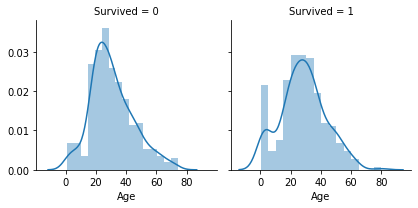

In [199]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Age")

In [200]:
print(train_data.Age.isna().sum())

177


There are some missing values that need to be dealt with. 

So we can replace the missing data with the average from similar passengers. 

For example, if we're missing the age of a 1st class passenger, who is female, who embarked from C. 

We could substitute in the age of other passengers who fit that description.

In [201]:

def find_similar_passengers(id, dataset):
    subset = dataset[(dataset.title == dataset.title[id]) &
                     (dataset.Pclass == dataset.Pclass[id])]

    if subset["Age"].mean() == "NaN":
        subset = dataset[(dataset["sex_class"] == dataset.iloc[id]["sex_class"])]

    if subset["Age"].mean() == "NaN":
        subset = dataset[(dataset["sex"] == dataset.iloc[id]["sex"])]

    age = subset["Age"].mean()
    return age


In [202]:
no_ages = train_data[train_data["Age"].isna()].index
for pid in no_ages:
    train_data.Age[pid] = find_similar_passengers(pid, train_data)

no_ages_test = test_data[test_data["Age"].isna()].index
for pid2 in no_ages_test:
    test_data.Age[pid2] = find_similar_passengers(pid2, test_data)

The missing data is filled in.

I think that children have a much higher survival rate and the elderly have a much lower.

So we can reorganise Age column by segmenting it into groups of <5, 5-65 and >65.


In [203]:
train_data["age_group"] = pd.cut(train_data["Age"], bins=[0, 5, 65, 100],
                                 labels=[0, 1, 2]).astype("int64")
test_data["age_group"] = pd.cut(test_data["Age"], bins=[0, 5, 65, 100],
                                labels=[0, 1, 2]).astype("int64")
print(train_data)

             Survived  Pclass  Sex  ...  Pclass_2  Pclass_3  age_group
PassengerId                         ...                               
1                   0       3    1  ...         0         1          1
2                   1       1    0  ...         0         0          1
3                   1       3    0  ...         0         1          1
4                   1       1    0  ...         0         0          1
5                   0       3    1  ...         0         1          1
...               ...     ...  ...  ...       ...       ...        ...
887                 0       2    1  ...         1         0          1
888                 1       1    0  ...         0         0          1
889                 0       3    0  ...         0         1          1
890                 1       1    1  ...         0         0          1
891                 0       3    1  ...         0         1          1

[891 rows x 687 columns]


**5)SibSp and Parch variables**

SibSp: The number of siblings or spouses aboard the titanic.

Parch: The number of parents/children aboard the titanic.

Both of them have the straight relation to family size, so we can add them together.

In [204]:
train_data[['SibSp', 'Survived']].groupby(['SibSp'],
                                          as_index=False).mean().sort_values(
                                              by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [205]:
train_data[['Parch', 'Survived']].groupby(['Parch'],
                                          as_index=False).mean().sort_values(
                                              by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


As we can see that smaller families tended to survive more than larger families.


In [206]:
train_data["fsize"] = train_data["SibSp"] + train_data["Parch"] + 1
test_data["fsize"] = test_data["SibSp"] + test_data["Parch"] + 1

In [207]:
train_data[['fsize', 'Survived']].groupby(['fsize'],
                                          as_index=False).mean().sort_values(
                                              by='Survived', ascending=False)

,fsize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Small families (4 or less) survived better than people who were alone or in bigger families.

**6)Ticket**

In [208]:
print(train_data.Ticket.nunique())
print(train_data.Ticket.isna().sum())
print(train_data.Ticket.tail())

681
0
PassengerId
887        211536
888        112053
889    W./C. 6607
890        111369
891        370376
Name: Ticket, dtype: object


As we can see tickets are numbers with some prefix letters.

Let's separate them.

In [209]:
train_data["ticket_prefix"] = pd.Series([len(i.split()) > 1 for i in
                                         train_data.Ticket],
                                        index=train_data.index)

In [210]:
train_data[['ticket_prefix', 'Survived']].groupby(
    ['ticket_prefix'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)

,ticket_prefix,Survived
1,True,0.384956
0,False,0.383459


The survival variable doesn't depand on weather ticket has prefix or not. 

I can conclude that ticket variable makes no impact on the result.

So let's get rid of it.

In [211]:
train_data.drop("ticket_prefix", axis=1, inplace=True)
train_data.drop("Ticket", axis=1, inplace=True)
test_data.drop("Ticket", axis=1, inplace=True)

**7)Fare**

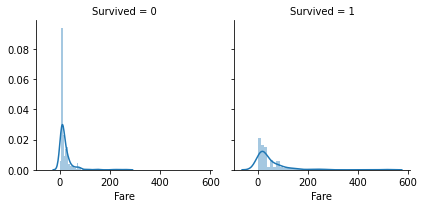

In [212]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Fare")

You can see that survivors had more expensive fares and a wider spread of fare prices. 

There is at least one outlier with a fare of >500 so dropping it.

The data is pretty skewed. Take a log transformation to reduce the skew and to decrease the massive range in fares.

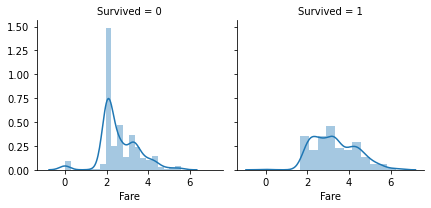

In [213]:
train_data["Fare"] = train_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
test_data["Fare"] = test_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Fare")

**8)Cabin**

In terms of a big amout of missing values i decided to drop this column.

Also i think it makes no impact on the result.

In [214]:
train_data.drop("Cabin", axis=1, inplace=True)
test_data.drop("Cabin", axis=1, inplace=True)

**9)Embarked**

 Let's fill in missing values as S.

 And encode it by using dummy variable.

In [215]:
train_data["Embarked"] = train_data["Embarked"].fillna("S")
train_data[['Embarked', 'Survived']].groupby(
    ['Embarked'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [216]:
print(train_data.Embarked.isna().sum())

0


In [217]:
train_data = train_data.join(pd.get_dummies(train_data['Embarked'],
                                            prefix="Embarked_"))
test_data = test_data.join(pd.get_dummies(test_data['Embarked'],
                                          prefix="Embarked_"))

In [218]:
train_data.drop("Embarked", axis=1, inplace=True)
test_data.drop("Embarked", axis=1, inplace=True)

**3)Data Normalization/Standartization.**

Firstly, let's split our dataframes up into the independant variables (matrix X) 

and the dependant variable (the vector y).

In terms of our independant variables have different scale we are supposed 

to normalize it by using StandartScaler(Z-normalization).

In [219]:
ss = StandardScaler()

train_y = train_data["Survived"]
train_data.drop("Survived", axis=1, inplace=True)

scoring_method = "f1"

train_scaled = ss.fit_transform(train_data)
test_scaled = ss.transform(test_data)

In [220]:
print(train_data.isna().sum())
print(test_data.isna().sum())


Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
              ..
age_group      0
fsize          0
Embarked__C    0
Embarked__Q    0
Embarked__S    0
Length: 687, dtype: int64
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
              ..
age_group      0
fsize          0
Embarked__C    0
Embarked__Q    0
Embarked__S    0
Length: 687, dtype: int64


I can conclude that our data is prepared for using.

**4)Modeling**

For each model i used GridSeachCV that allows me to create 

grid of possible values for the parameters and it will test 

all possible combinations, storing the best result.

So i won't search the best parameters manually, but it's brude force algorithm and it will take a while to finish.



*1)LogisticRegression*

In [221]:
model = LogisticRegression(random_state=10, max_iter=1000)
logit_params = {
    "C": [1, 3, 10, 20, 30, 40],
    "solver": ["lbfgs", "liblinear"]
}
logit_gs = GridSearchCV(model, logit_params, scoring="f1", cv=5, n_jobs=4)

In [222]:
logit_gs.fit(train_data, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [1, 3, 10, 20, 30, 40],
                         'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [223]:
print(logit_gs.best_params_)
print(logit_gs.best_score_)

{'C': 20, 'solver': 'lbfgs'}
0.7788805987409215


*2)RandomForest*

In [224]:
rf_model = RandomForestClassifier()

rf_params = {
    'bootstrap': [True, False],
    'max_depth': [10, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [5, 10, 15, 20, 25, 30]}

rf_gs = GridSearchCV(rf_model, rf_params,
                     scoring=scoring_method, cv=8, n_jobs=4)

In [225]:
rf_gs.fit(train_data, train_y)

GridSearchCV(cv=8, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [226]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}
0.7788673858584831


*3)Support Vector Machine*

In [227]:
svc_model = SVC()

test_parameters = {
    "C": [1, 3, 10, 30, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}
svc_gs = GridSearchCV(svc_model, test_parameters, scoring="f1", cv=5, n_jobs=4)

In [228]:
svc_gs.fit(train_scaled, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [1, 3, 10, 30, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [229]:
print(svc_gs.best_params_)
print(svc_gs.best_score_)

{'C': 10, 'kernel': 'sigmoid'}
0.7853251729903806


*4)Light Gradient Boosting*

In [230]:
lgb_model = LGBMClassifier()
test_parameters = {
    "n_estimators": [int(x) for x in np.linspace(5, 30, 6)],
    "reg_alpha": [0, 0.75, 1, 1.25],
    "learning_rate": [0.5, 0.4, 0.35, 0.3, 0.25, 0.2],
    "subsample": [0.5, 0.75, 1]
}
lgb_gs = GridSearchCV(lgb_model, test_parameters,
                      scoring=scoring_method, cv=8, n_jobs=4)

In [231]:
lgb_gs.fit(train_data, train_y)

GridSearchCV(cv=8, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [0.5, 0.4, 0.35, 0.3, 0.25, 0.2],
                     

In [232]:
print(lgb_gs.best_params_)
print(lgb_gs.best_score_)

{'learning_rate': 0.4, 'n_estimators': 15, 'reg_alpha': 1.25, 'subsample': 0.5}
0.7888003510716926


*5)XGBoost*

In [233]:
xgb_model = XGBClassifier()

parameters = {'nthread': [4],
              'objective': ['binary:logistic'],
              'learning_rate': [0.05],
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5],
              'missing': [-999],
              'seed': [1337]}


xgb_gs = GridSearchCV(xgb_model, parameters,
                      scoring=scoring_method, cv=8, n_jobs=5)

xgb_gs.fit(train_data, train_y)

GridSearchCV(cv=8, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [6], 'min_child_weight': [11],
                         'missing': [-999], 'n_estimators': [5], '

In [234]:
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
0.7282821314687667


*6)CatBoost*

In [235]:
catBoost = CatBoostClassifier()
test_parameters = {'iterations': [500],
                   'depth': [4, 5, 6],
                   'loss_function': ['Logloss', 'CrossEntropy'],
                   'l2_leaf_reg': np.logspace(-20, -19, 3),
                   'leaf_estimation_iterations': [10],
                   'logging_level': ['Silent'],
                   'random_seed': [42]
                   }
catboost_gs = GridSearchCV(catBoost, test_parameters,
                           scoring=scoring_method, cv=5, n_jobs=4)

In [236]:
catboost_gs.fit(train_data, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fe8c4765240>,
             iid='deprecated', n_jobs=4,
             param_grid={'depth': [4, 5, 6], 'iterations': [500],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'leaf_estimation_iterations': [10],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy'],
                         'random_seed': [42]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [237]:
print(catboost_gs.best_params_)
print(catboost_gs.best_score_)

{'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
0.7790722545815794


**5)Comparing models.**

These different models are probably placing different levels of importance on different features/variables. 

I think the key to a good ensembler/voter is to have models that have different predictions. 

**6)Ensembling/Voting**

Let's use a voting classifier to use above models to make an overall prediction. 

I don't include XGBoost and CatBoost by the reason of overfitting.

When i include them i get 99 percent accuracy, but kaggle gives me worse results for this ensemble.

But without it ii get better results on keggle.

Am i correct of naming it as overfitting?





Also i faced with the problem that VotingClassifier no longer willing 

to apply all of the models during fit function working. 

The result on kaggle would be better if it worked properly.

In [238]:
ensemble_model = VotingClassifier(estimators=[
    ("logit", logit_gs.best_estimator_),
    ("rf", rf_gs.best_estimator_),
    ("svc", svc_gs.best_estimator_),
    ("lgb", lgb_gs.best_estimator_),
    # ("xgb", xgb_gs.best_estimator_),
    # ("catboost", catboost_gs.best_estimator_),
], voting="hard")

print(ensemble_model.estimators)

[('logit', LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('rf', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)), ('svc', SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shap

In [239]:
ensemble_model.fit(train_data, train_y)

VotingClassifier(estimators=[('logit',
                              LogisticRegression(C=20, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=10,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                            

In [240]:
ensemble_model.score(train_data, train_y)

0.9438832772166106

In [241]:
preds = ensemble_model.predict(test_data)

In [242]:
output = pd.DataFrame({'PassengerId': test_data.index,
                       'Survived': preds})

output.to_csv('submission.csv', index=False)